### <prophet 시계열 예측 모델>

- 장점 : 누구나 어렵지 않게 사용 가능한 모델

- 단점 : 설치 시 설치된 다른 라이브러리들과 버전 충돌이 간혹 발생함

In [1]:
### 기본 라이브러리

import pandas as pd
import matplotlib.pyplot as plt
import platform
import datetime
import yfinance as yf

import prophet
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
print(f'{platform.system()}운영체제입니다.')

Windows운영체제입니다.


In [3]:
### google 주식 데이터 수집하기
# - Google 기업은 야후에서 'GOOG' 이름으로 종목명이 되어 있다.

# - 오늘 기준으로 과거 5년치 데이터 수집하기
goog_data = yf.download('GOOG',period='5y')

[*********************100%%**********************]  1 of 1 completed


In [4]:
goog_data
# - Open : 시작가
# - High : 상한가
# - Low : 하한가
# - Close : 종가
# - Adj Close : 수정종가(분할, 배당, 배분, 신주 등 발생한 경우 조정이 이루어진 값)
# - volume : 거래

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-02,59.765999,60.067501,59.285500,60.024502,60.024502,16558000
2019-04-03,60.374001,60.814999,60.025002,60.296001,60.296001,20286000
2019-04-04,60.297001,60.783501,60.206501,60.750000,60.750000,19000000
2019-04-05,60.749500,60.811001,60.251499,60.357498,60.357498,18144000
2019-04-08,60.394501,60.434502,59.993000,60.192001,60.192001,17204000
...,...,...,...,...,...,...
2024-03-25,150.949997,151.455994,148.800003,151.149994,151.149994,15114700
2024-03-26,151.240005,153.199997,151.029999,151.699997,151.699997,19312700
2024-03-27,152.145004,152.690002,150.130005,151.940002,151.940002,16622000


In [5]:
goog_data.info()

### 시계열 분석에서는 기준값(x)는 날짜 타입을 가진다.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-04-02 to 2024-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


### 원본을 복제하여 사용

#### <데이터 처리 순서>

1. Date index를 컬럼 데이터로 변환

2. 훈련에 사용할 컬럼 : Date, Adj Close

3. 훈련에 사용하지 않는 컬럼 삭제

4. 훈련에 사용할 컬럼명 변경 :Date ->ds, Adj Close -> y

In [6]:
prophet_data = goog_data.copy()
prophet_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-02,59.765999,60.067501,59.285500,60.024502,60.024502,16558000
2019-04-03,60.374001,60.814999,60.025002,60.296001,60.296001,20286000
2019-04-04,60.297001,60.783501,60.206501,60.750000,60.750000,19000000
2019-04-05,60.749500,60.811001,60.251499,60.357498,60.357498,18144000
2019-04-08,60.394501,60.434502,59.993000,60.192001,60.192001,17204000
...,...,...,...,...,...,...
2024-03-25,150.949997,151.455994,148.800003,151.149994,151.149994,15114700
2024-03-26,151.240005,153.199997,151.029999,151.699997,151.699997,19312700
2024-03-27,152.145004,152.690002,150.130005,151.940002,151.940002,16622000


In [7]:
### 1. Date index를 컬럼 데이터로 변환
prophet_data.reset_index(inplace=True)
prophet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Open       1258 non-null   float64       
 2   High       1258 non-null   float64       
 3   Low        1258 non-null   float64       
 4   Close      1258 non-null   float64       
 5   Adj Close  1258 non-null   float64       
 6   Volume     1258 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


In [8]:
### 2. 훈련에 사용하지 않는 컬럼 삭제
prophet_data.drop(columns=['Open','High','Low','Close','Volume'],axis=1, inplace=True)

In [9]:
prophet_data

,Date,Adj Close
0,2019-04-02,60.024502
1,2019-04-03,60.296001
2,2019-04-04,60.750000
3,2019-04-05,60.357498
4,2019-04-08,60.192001
...,...,...
1253,2024-03-25,151.149994
1254,2024-03-26,151.699997
1255,2024-03-27,151.940002
1256,2024-03-28,152.259995


In [10]:
### 훈련에 사용할 컬럼영을 Date는 ds로, Adj Close는 y로 변경하기
prophet_data.columns= ['ds','y']
prophet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1258 non-null   datetime64[ns]
 1   y       1258 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


### <prophet 시계열 예측 모델>

- 시계열 예측을 그래프(시각화)로 표현하는 모델

- prophet에서 사용하는 컬럼명은 ds와 y 컬럼명을 사용하기 때문에 기존 컬럼명을 ds와 y로 수정해서 사용해야 한다.

In [11]:
### prophet 모델 생성하기
# - daily_seasonality : 일단위 주기성 활성화(True) -> 일단위 주기성을 보여주는 예측을 의미
model = prophet.Prophet(daily_seasonality=True)
model

In [12]:
### 우리나라 공휴일 정보 이용하기
model.add_country_holidays(country_name='KR')

In [13]:
### 모델 훈련 시키기
# - 독립변수와 종속변수를 분리하지 않고 데이터 전체를 넣어줌
model.fit(prophet_data)

19:30:18 - cmdstanpy - INFO - Chain [1] start processing
19:30:19 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
### 예측을 위한 기간 추출하기(향후 예측 기간)
# - 3년 간 예측하기
# - 조회 결과는 기존 기간의 시작부터 끝값 + 3년까지의 모든 기간을 자동 생성한다.
future = model.make_future_dataframe(periods=365*3)
future

,ds
0,2019-04-02
1,2019-04-03
2,2019-04-04
3,2019-04-05
4,2019-04-08
...,...
2348,2027-03-28
2349,2027-03-29
2350,2027-03-30
2351,2027-03-31


In [15]:
### 기존 기간에 더하여 3년 이후까지 예측하기
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday for Buddha's Birthday,Alternative holiday for Buddha's Birthday_lower,Alternative holiday for Buddha's Birthday_upper,Alternative holiday for Children's Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-04-02,59.509438,52.893017,63.472661,59.509438,59.509438,0.0,0.0,0.0,0.0,...,-0.106466,-0.106466,-0.106466,-1.321866,-1.321866,-1.321866,0.0,0.0,0.0,58.308155
1,2019-04-03,59.462214,52.855695,64.415638,59.462214,59.462214,0.0,0.0,0.0,0.0,...,-0.014693,-0.014693,-0.014693,-1.126867,-1.126867,-1.126867,0.0,0.0,0.0,58.547702
2,2019-04-04,59.414991,53.236008,64.375820,59.414991,59.414991,0.0,0.0,0.0,0.0,...,0.125509,0.125509,0.125509,-0.954248,-0.954248,-0.954248,0.0,0.0,0.0,58.813300
3,2019-04-05,59.367767,53.318034,64.713818,59.367767,59.367767,0.0,0.0,0.0,0.0,...,0.129279,0.129279,0.129279,-0.804808,-0.804808,-0.804808,0.0,0.0,0.0,58.919286
4,2019-04-08,59.226096,53.392822,64.290994,59.226096,59.226096,0.0,0.0,0.0,0.0,...,-0.076868,-0.076868,-0.076868,-0.500115,-0.500115,-0.500115,0.0,0.0,0.0,58.876161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,2027-03-28,293.131136,97.559163,491.571747,100.685377,492.508823,0.0,0.0,0.0,0.0,...,-0.028381,-0.028381,-0.028381,-2.589911,-2.589911,-2.589911,0.0,0.0,0.0,290.739892
2349,2027-03-29,293.258677,95.670318,491.367573,100.625555,492.911828,0.0,0.0,0.0,0.0,...,-0.076868,-0.076868,-0.076868,-2.302272,-2.302272,-2.302272,0.0,0.0,0.0,291.106586
2350,2027-03-30,293.386218,99.543120,490.354620,100.565733,493.264263,0.0,0.0,0.0,0.0,...,-0.106466,-0.106466,-0.106466,-2.029946,-2.029946,-2.029946,0.0,0.0,0.0,291.476855
2351,2027-03-31,293.513760,97.758876,488.858156,100.505911,493.602160,0.0,0.0,0.0,0.0,...,-0.014693,-0.014693,-0.014693,-1.774727,-1.774727,-1.774727,0.0,0.0,0.0,291.951388


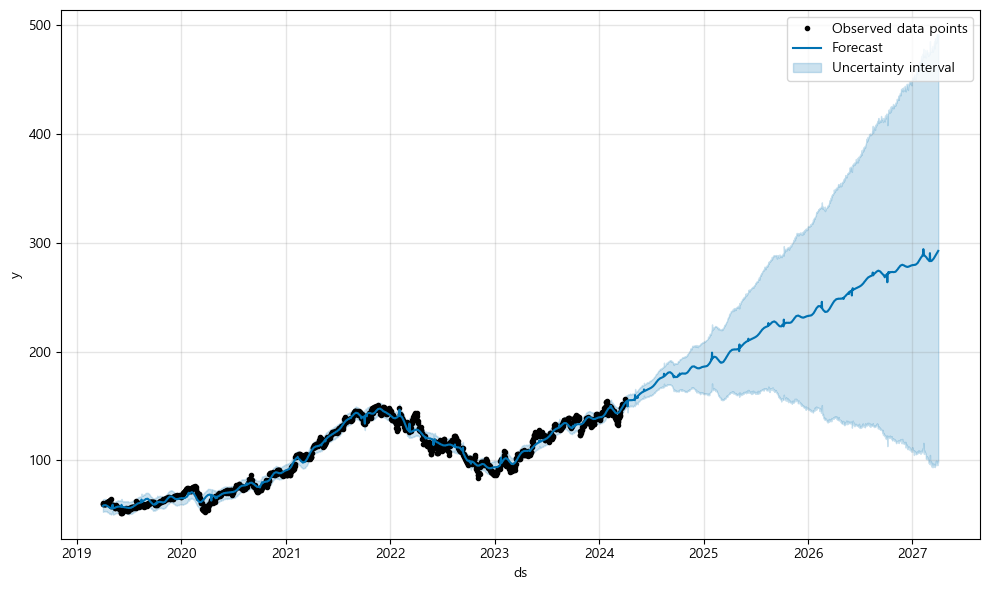

In [16]:
### 예측 결과 시가화하기
# - 예측 결과 넣어주기 : forecast
model.plot(forecast)
plt.legend()
plt.show()

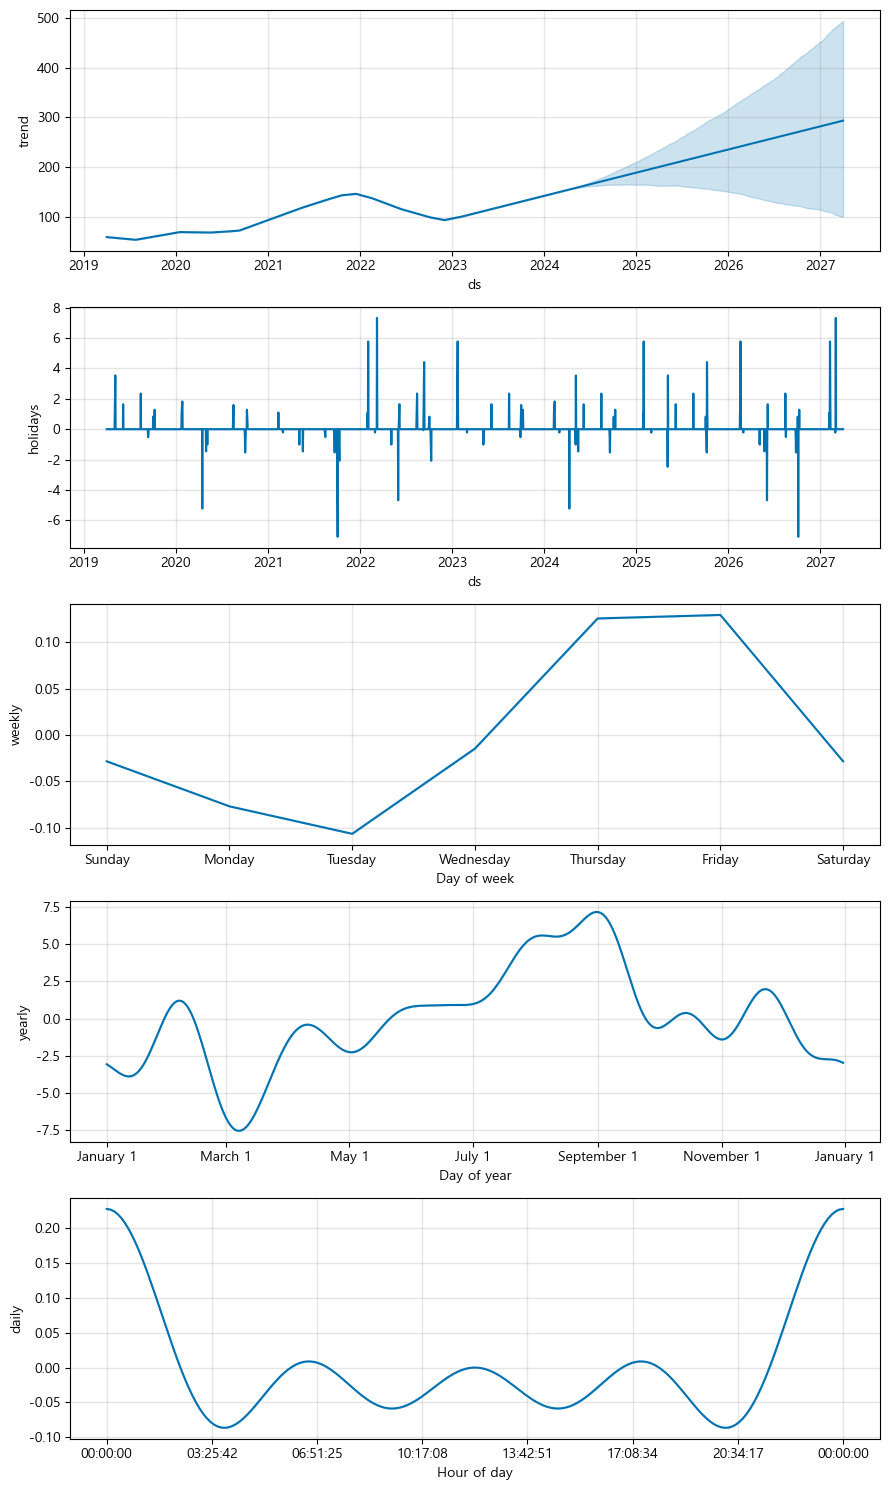

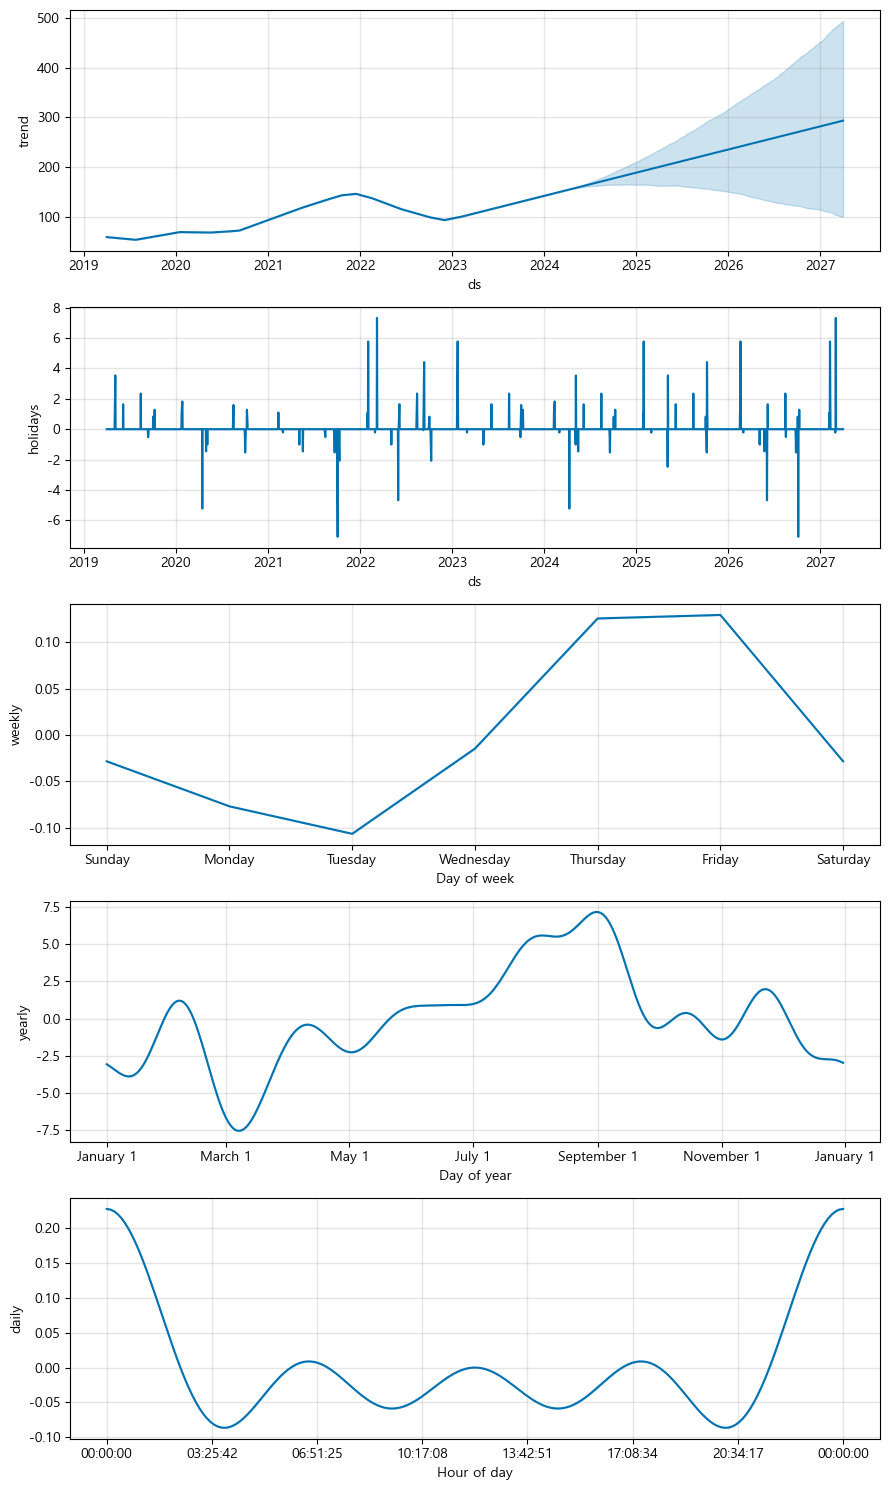

In [17]:
### 트렌드(추이), 연간, 주간 등의 추이 데이터 시각화
model.plot_components(forecast)